## 밤시간대 전기사용량 많은 이유?

### 다른 survey 응답 통해 확인

In [2]:
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

### 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan

helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

### 라벨 로드
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
# Interviedate가 빠른 순으로 정렬
SAVE_label.sort_values('InterviewDate', inplace = True)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

# 라벨 순서를 데이터 순서와 맞춤
valid_col = []
for col in SAVE.columns:
    if col in SAVE_label.columns:
        valid_col.append(col)

SAVE_label = SAVE_label[valid_col].T
SAVE = SAVE[valid_col]
print('Done')

Done


In [61]:
print(SAVE.shape)

print(SAVE_label.shape)

(86724, 3934)
(3934, 300)


### Gas 보유 가정 수 확인

In [2]:
from module.util_save import matching_id

data_f, label_f = matching_id(SAVE, SAVE_label, 'Q3_6')

In [5]:
v, c = np.unique(label_f, return_counts = True)
'''
1: 보유 / main ?
2: 보유 / LPG
3. 없음
4. 모름
=> 대부분이 가스를 사용
'''
print(v)
print(c)

[1. 2. 3. 4.]
[3590   32  259   22]


### Gas가 없는 집에서도 밤시간대 사용량이 많은지?

In [15]:
# Gas
data_f, label_f = matching_id(SAVE, SAVE_label, 'Q3_6')

In [21]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-02-01 23:00:00')

# dim reduct
# 가스 사용
data_1 = data_f.loc[start_date:end_date,label_f < 3].values
data_1, _ = dim_reduct(data_1, 24*4, 0)
data_1 = downsampling(data_1, 4)

# 가스 미사용
data_2 = data_f.loc[start_date:end_date,label_f == 3].values
data_2, _ = dim_reduct(data_2, 24*4, 0)
data_2 = downsampling(data_2, 4)

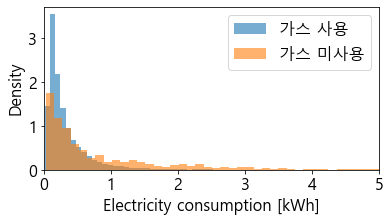

In [26]:
plt.figure(figsize = (6,3))
plt.title('')
plt.hist(data_1[:,12:18].reshape(-1), label = '가스 사용', bins = 100, alpha = 0.6, density = True)
plt.hist(data_2[:,12:18].reshape(-1), label = '가스 미사용', bins = 100, alpha = 0.6, density = True)
plt.ylabel('Density')
plt.xlabel('Electricity consumption [kWh]')
plt.legend()
plt.xlim(0, 5)
plt.show()

* 당연하지만 가스 사용 안 하는 집이 전기사용량 더 많음

### 가스 사용 안 하는 집의 사람수와의 correlation

In [206]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-03-01 23:00:00')

data_dict = dict()
for i in [1, 3]:
    data = SAVE.loc[start_date:end_date,:].values
    data, idx = dim_reduct(data, 24*4, 0)
    data = downsampling(data, 4)
    label = SAVE_label.iloc[idx,:]
    valid_idx = label['Q3_6'] == i
    label = label.loc[valid_idx,'Q2'].values
    data = data[valid_idx.values,:]

    valid_idx = ~pd.isnull(label)
    label = label[valid_idx].astype(int)
    data = data[valid_idx]

    data_dict[i] = (data, label)

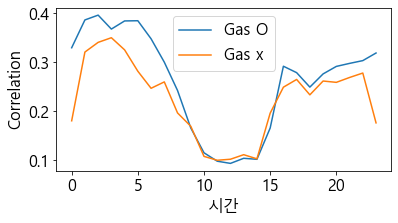

In [209]:
plt.figure(figsize = (6,3))
for i in [1, 3]:
    data, label = data_dict[i]
    corr_list = []
    for j in range(24):
        corr_list.append(np.corrcoef(data[:,j], label)[0,1])
    plt.plot(corr_list)
plt.xlabel('시간')
# plt.xticks(range(24)[::6], (np.array(range(24))/2)[::6].astype(int))
plt.ylabel('Correlation')
plt.legend(['Gas O','Gas x'])
plt.show()

* Gas가 영향이 있긴 한거같음

## EV

In [210]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-03-01 23:00:00')

data_dict = dict()
for i in [1, 2]:
    data = SAVE.loc[start_date:end_date,:].values
    data, idx = dim_reduct(data, 24*4, 0)
    data = downsampling(data, 4)
    label = SAVE_label.iloc[idx,:]
    valid_idx = label['Q6_1'] == i
    label = label.loc[valid_idx,'Q2'].values
    data = data[valid_idx.values,:]

    valid_idx = ~pd.isnull(label)
    label = label[valid_idx].astype(int)
    data = data[valid_idx]

    data_dict[i] = (data, label)

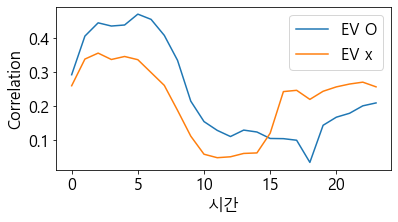

In [211]:
plt.figure(figsize = (6,3))
for i in [1, 2]:
    data, label = data_dict[i]
    corr_list = []
    for j in range(24):
        corr_list.append(np.corrcoef(data[:,j], label)[0,1])
    plt.plot(corr_list)
plt.xlabel('시간')
# plt.xticks(range(24)[::6], (np.array(range(24))/2)[::6].astype(int))
plt.ylabel('Correlation')
plt.legend(['EV O','EV x'])
plt.show()

## Heat

In [212]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-03-01 23:00:00')

data_dict = dict()
for i in [1, 2]:
    data = SAVE.loc[start_date:end_date,:].values
    data, idx = dim_reduct(data, 24*4, 0)
    data = downsampling(data, 4)
    label = SAVE_label.iloc[idx,:]
    if i == 1:
        valid_idx = label['Q3_12'] <= 2
    else:
        valid_idx = label['Q3_12'] > 2
    label = label.loc[valid_idx,'Q2'].values
    data = data[valid_idx.values,:]

    valid_idx = ~pd.isnull(label)
    label = label[valid_idx].astype(int)
    data = data[valid_idx]

    data_dict[i] = (data, label)

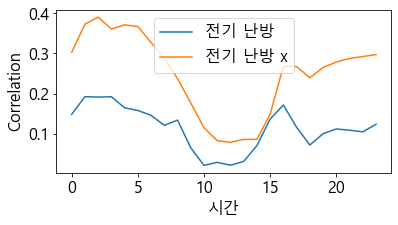

In [213]:
plt.figure(figsize = (6,3))
for i in [1, 2]:
    data, label = data_dict[i]
    corr_list = []
    for j in range(24):
        corr_list.append(np.corrcoef(data[:,j], label)[0,1])
    plt.plot(corr_list)
plt.xlabel('시간')
# plt.xticks(range(24)[::6], (np.array(range(24))/2)[::6].astype(int))
plt.ylabel('Correlation')
plt.legend(['전기 난방','전기 난방 x'])
plt.show()

## CER Gas 확인

In [167]:
# CER
CER = pd.read_csv('data/CER/power_comb.csv', index_col=0)
CER.index = pd.to_datetime(CER.index)S
start_date = pd.to_datetime('2010-01-01 00:00:00')
end_date = pd.to_datetime('2010-03-01 23:00:00')
CER = CER.loc[start_date:end_date,:]

In [6]:
path = 'D:/ISP/3. 데이터/ENERGY/38_CER Electricity_Gas/CER Electricity Revised March 2012/CER_Electricity_Data/'
survey_raw = pd.read_csv(path + 'Smart meters Residential pre-trial survey data.csv', encoding='cp1252', low_memory=False)
survey_raw.set_index('ID', inplace=True)
# replace blanks
for j in range(survey_raw.shape[1]):
    for i in range(survey_raw.shape[0]):
        try:
            int(survey_raw.iloc[i, j])
        except:
            survey_raw.iloc[i, j] = -1

for j in range(survey_raw.shape[1]):
    survey_raw.iloc[:, j] = survey_raw.iloc[:, j].astype(int)

In [10]:
data = survey_raw['Question 470: Which of the following best describes how you heat your: Gas']

v, c = np.unique(data, return_counts=True)
print(v)
print(c)

[0 1]
[2826 1406]


* SAVE보단 상대적으로 GAS 비율이 낮음

In [166]:
Q470 = 'Question 470: Which of the following best describes how you heat your: Gas'
Q420 = 'Question 420: How many people over 15 years of age live in your home?'
Q43111 = 'Question 43111: How many people under 15 years of age live in your home?'

In [194]:
data_dict = dict()
for i in [0, 1]:
    gas_idx = survey_raw[Q470] == i

    valid_idx_1 = survey_raw.loc[gas_idx, Q43111] > 0
    valid_idx_2 = survey_raw.loc[gas_idx, Q420] > 0
    valid_idx = valid_idx_1.values * valid_idx_2.values

    label = survey_raw.loc[gas_idx, :][valid_idx]
    label = label[Q43111] + label[Q420]

    data = CER[label.index.astype(str)]
    data, idx = dim_reduct(data.values, 24*2, 0)
    data = downsampling(data, 2)
    label = label.iloc[idx]

    data_dict[i] = (data, label)

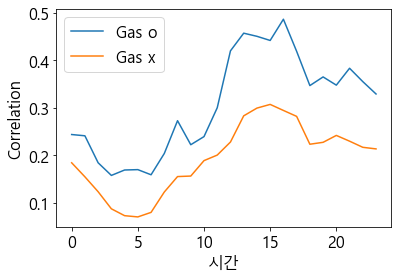

In [196]:
for i in [1, 0]:
    data, label = data_dict[i]
    corr_list = []
    for j in range(24):
        corr_list.append(np.corrcoef(data[:,j], label)[0,1])
    plt.plot(corr_list)
plt.xlabel('시간')
# plt.xticks(range(24)[::6], (np.array(range(24))/2)[::6].astype(int))
plt.ylabel('Correlation')
plt.legend(['Gas o','Gas x'])
plt.show()

## Gas 안쓰고 전기난방 아니고 EV 없는 집 조사

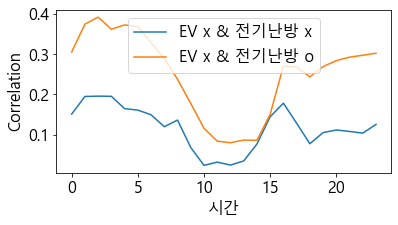

In [11]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-03-01 23:00:00')
plt.figure(figsize = (6,3))

for i in [1, 2]:
    data = SAVE.loc[start_date:end_date,:].values
    data, idx = dim_reduct(data, 24*4, 0)
    data = downsampling(data, 4)
    label = SAVE_label.iloc[idx,:]
    if i == 1:
        valid_idx = (label['Q6_1'] == 2) * (label['Q3_12'] <= 2) 
    else:
        valid_idx = (label['Q6_1'] == 2) * (label['Q3_12'] > 2) 
    label = label.loc[valid_idx,'Q2'].values
    data = data[valid_idx.values,:]

    valid_idx = ~pd.isnull(label)
    label = label[valid_idx].astype(int)
    data = data[valid_idx]

    corr_list = []
    for j in range(24):
        corr_list.append(np.corrcoef(data[:,j], label)[0,1])
    plt.plot(corr_list)
    plt.xlabel('시간')
    # plt.xticks(range(24)[::6], (np.array(range(24))/2)[::6].astype(int))
    plt.ylabel('Correlation')
plt.legend(['EV x & 전기난방 x','EV x & 전기난방 o'])
plt.show()